# YouTube Analysis and Recommender System

In this notebook, we perform a detailed analysis of YouTube data to build a recommender system. YouTube, being one of the largest video-sharing platforms, holds a wealth of information that can be leveraged to understand user preferences, predict trends, and suggest relevant content.

## Overview

This project focuses on analyzing YouTube videos, their metadata, user interactions, and building a system that can recommend videos based on different factors such as view history, user preferences, and similar content.

## Objectives

- **Data Collection**: Retrieve YouTube video data, including video titles, descriptions, view counts, likes, and comments.
- **Data Preprocessing**: Clean and prepare the dataset for analysis.
- **Exploratory Data Analysis (EDA)**: Investigate patterns, trends, and insights from the dataset.
- **Recommender System**: Build a content-based or collaborative filtering recommender system to suggest videos to users.
- **Evaluation**: Evaluate the recommender system using appropriate metrics like accuracy, precision, and recall.

## Dataset

The dataset used in this analysis is collected from publicly available YouTube video statistics. It includes various features such as:

- Video Title
- Channel Name
- View Count
- Like Count
- Comment Count
- Video Description
- Tags
- Published Date

## Methodology

We will employ machine learning algorithms to build our recommender system. Depending on the approach, we might use:
- **Content-Based Filtering**: Recommending videos based on similarities between the content of videos.
- **Collaborative Filtering**: Recommending videos based on user interaction history and preferences.

The model will be evaluated based on the ability to suggest relevant and engaging videos to users.

## Conclusion

By the end of this notebook, we aim to have a fully functional recommender system capable of providing personalized video recommendations, enhancing user engagement, and improving their overall experience on YouTube.



## Initializing PySpark

Before using PySpark, we need to initialize the Spark session.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys

## Load the Data from a CSV file

In [2]:
filePath = os.path.join(os.getcwd(), "dataset", "trending_yt_videos_113_countries.csv")
data = pd.read_csv(filePath, sep=',')
data.head(5)

,title,channel_name,daily_rank,daily_movement,weekly_movement,snapshot_date,country,view_count,like_count,comment_count,description,thumbnail_url,video_id,channel_id,video_tags,kind,publish_date,langauge
0,Jah Prayzah - Mandionei (Official Performance ...,Jah Prayzah,1,0,49,2025-02-20,ZW,640294,33578,6942,Our first single for 2025\nNot a part of the N...,https://i.ytimg.com/vi/hQGU7Hjr6KA/mqdefault.jpg,hQGU7Hjr6KA,UCPpVYvHuQSIkQwW1pJhfPrA,NaN,youtube#video,2025-02-17 00:00:00+00:00,NaN
1,Winky D - Siya,winkyonline,2,0,-1,2025-02-20,ZW,1483949,59662,10408,You can purchase the EP from stores below:\nSP...,https://i.ytimg.com/vi/Mq0J2Q4I71U/mqdefault.jpg,Mq0J2Q4I71U,UC9iqkdRHEbX7hwEu9D6J8wg,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
2,Winky D Fake Love (Official Ai Video),winkyonline,3,0,-1,2025-02-20,ZW,1031541,48158,6185,You can purchase the EP from stores below:\nSP...,https://i.ytimg.com/vi/6YvoX8x6aCw/mqdefault.jpg,6YvoX8x6aCw,UC9iqkdRHEbX7hwEu9D6J8wg,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,NFL,4,0,-1,2025-02-20,ZW,75930862,2735285,161203,Watch hip-hop’s MVP put on an epic performance...,https://i.ytimg.com/vi/KDorKy-13ak/mqdefault.jpg,KDorKy-13ak,UCDVYQ4Zhbm3S2dlz7P1GBDg,"NFL, Football, American Football, sport, sports",youtube#video,2025-02-10 00:00:00+00:00,en
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,Man City,5,45,45,2025-02-20,ZW,4166631,64473,3630,Manchester City were knocked out this season’s...,https://i.ytimg.com/vi/zpieZkvFnlE/mqdefault.jpg,zpieZkvFnlE,UCkzCjdRMrW2vXLx8mvPVLdQ,"man city, manchester city, mcfc, man city high...",youtube#video,2025-02-20 00:00:00+00:00,en-GB


# YouTube Dataset: Explicit vs. Implicit Data

Explicit data refers to information that is directly provided by the user, platform, or content creators,
whereas implicit data refers to information that is generated based on user interaction, platform algorithms, or system tracking.
In our dataset, we have a combination of both types of data, separated as follows:

## Explicit Data

- **title**: The title of the video, explicitly set by the uploader.
- **channel_name**: The name of the YouTube channel that uploaded the video.
- **description**: The text description provided by the video uploader.
- **thumbnail_url**: The URL of the thumbnail, explicitly assigned or auto-generated by YouTube.
- **video_id**: A unique identifier for the video, assigned by YouTube.
- **channel_id**: A unique identifier for the channel, assigned by YouTube.
- **video_tags**: Tags provided by the content creator for categorization and search optimization.
- **kind**: Indicates the type of content (e.g., YouTube video).
- **publish_date**: The date when the video was published, explicitly recorded by YouTube.
- **language** (or "langauge" as it appears in your dataset): The language setting for the video, either set by the uploader or inferred by YouTube.

## Implicit Data

- **daily_rank**: The ranking of the video for a given day, derived from engagement metrics.
- **daily_movement**: The change in ranking from the previous day, inferred from user engagement trends.
- **weekly_movement**: The ranking shift over a week, based on aggregated engagement data.
- **snapshot_date**: The date when the data was collected, recorded by the system.
- **country**: The country where the video is trending or where the snapshot was taken, inferred from viewer location data.
- **view_count**: The number of views the video has received, recorded and updated by YouTube.
- **like_count**: The number of likes, tracked as users interact with the content.
- **comment_count**: The number of comments, generated from user interactions.


## Filtering columns

As a starter to our project, we decided to cut some of the variables that are less likely to be userful in user recommendation. If needed, we will reload some of the columns needed.

In [3]:
columns_useful = ['title', 'channel_name', 'view_count', 'like_count', 'comment_count', 
                  'video_tags', 'kind', 'publish_date', 'langauge']

# Filter the columns that exist in the dataframe
columns_validas = [c for c in columns_useful if c in data.columns]

# Select only the valid columns
data = data[columns_validas]

# Display the first 5 rows
data.head(5)

,title,channel_name,view_count,like_count,comment_count,video_tags,kind,publish_date,langauge
0,Jah Prayzah - Mandionei (Official Performance ...,Jah Prayzah,640294,33578,6942,NaN,youtube#video,2025-02-17 00:00:00+00:00,NaN
1,Winky D - Siya,winkyonline,1483949,59662,10408,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
2,Winky D Fake Love (Official Ai Video),winkyonline,1031541,48158,6185,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,NFL,75930862,2735285,161203,"NFL, Football, American Football, sport, sports",youtube#video,2025-02-10 00:00:00+00:00,en
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,Man City,4166631,64473,3630,"man city, manchester city, mcfc, man city high...",youtube#video,2025-02-20 00:00:00+00:00,en-GB


## Generating new dimensions

We decided to create a new column called "Engagement Score" that uses a function of weights to generate a number that explains user interaction with the video.

We used a simple formula as shown below: 

$$
\text{Engagement Score} = \frac{\text{like\_count} \times 2 + \text{comment\_count} \times 3}{\text{view\_count} + 1}
$$


We decided to use these weights taking account the level of effort the user needs to put in order to perform these actions, meaning that they are more important the harder it is to do. The +1 on the view count is in order to avoid divisions by zero.

In [4]:
# Creating the engagement score column
data['engagement_score'] = (data['like_count'] * 2 + data['comment_count'] * 3) / (data['view_count'] + 1)

# Sorting by engagement score in descending order
data_sorted = data.sort_values(by='engagement_score', ascending=False)

# Display the first 5 rows
data_sorted.head(5)

,title,channel_name,view_count,like_count,comment_count,video_tags,kind,publish_date,langauge,engagement_score
876704,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,456719,11537,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,948049.0
882352,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,455188,11468,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,944780.0
887999,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,453200,11386,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,940558.0
893641,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,450683,11282,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,935212.0
899284,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,447515,11143,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,928459.0


## Normalising the Score

In [5]:
# Calculate min and max values of the engagement_score
min_score = data['engagement_score'].min()
max_score = data['engagement_score'].max()

# Create the scaled engagement score column
data['scaled_engagement_score'] = 1 + 9 * ((data['engagement_score'] - min_score) / (max_score - min_score))

# Select the relevant columns and sort by scaled_engagement_score in descending order
data_sorted = data[['title', 'engagement_score', 'scaled_engagement_score']].sort_values(by='scaled_engagement_score', ascending=False)

# Display the first 5 rows
data_sorted.head(5)



,title,engagement_score,scaled_engagement_score
876704,THE WEEKND - SÃO PAULO LIVESTREAM,948049.0,10.000000
882352,THE WEEKND - SÃO PAULO LIVESTREAM,944780.0,9.968967
887999,THE WEEKND - SÃO PAULO LIVESTREAM,940558.0,9.928887
893641,THE WEEKND - SÃO PAULO LIVESTREAM,935212.0,9.878136
899284,THE WEEKND - SÃO PAULO LIVESTREAM,928459.0,9.814029


## Data Association

We will now dive deeper in our dataset, generating different datasets that provide different information on our data

In [6]:
# Group by 'channel_name' and calculate the average engagement score
channel_engagement = data.groupby('channel_name')['engagement_score'].mean().reset_index()
channel_engagement = channel_engagement.rename(columns={'engagement_score': 'avg_engagement_score'})

# Calculate min and max of avg_engagement_score
min_score_channel = channel_engagement['avg_engagement_score'].min()
max_score_channel = channel_engagement['avg_engagement_score'].max()

# Create the scaled average engagement score column
channel_engagement['scaled_avg_engagement_score'] = 1 + 9 * ((channel_engagement['avg_engagement_score'] - min_score_channel) / (max_score_channel - min_score_channel))

# Sort by avg_engagement_score in descending order
channel_analysis = channel_engagement.sort_values(by='avg_engagement_score', ascending=False)

# Display the top 10 rows
channel_analysis.head(10)


,channel_name,avg_engagement_score,scaled_avg_engagement_score
26687,The Weeknd,267825.547331,10.000000
5557,Coachella,226829.630104,8.622375
10524,GoogleDoodles,165461.954545,6.560178
1674,Alok,23462.932742,1.788448
13857,Kenia Os,18924.956264,1.635954
8695,FORMULA 1,6430.476832,1.216090
9282,Flow Podcast,3586.588321,1.120524
13273,KAROL G,363.453403,1.012213
255,2SekundovyMato,90.802832,1.003051
19466,Nour Chiba نور شيبة,1.296628,1.000044


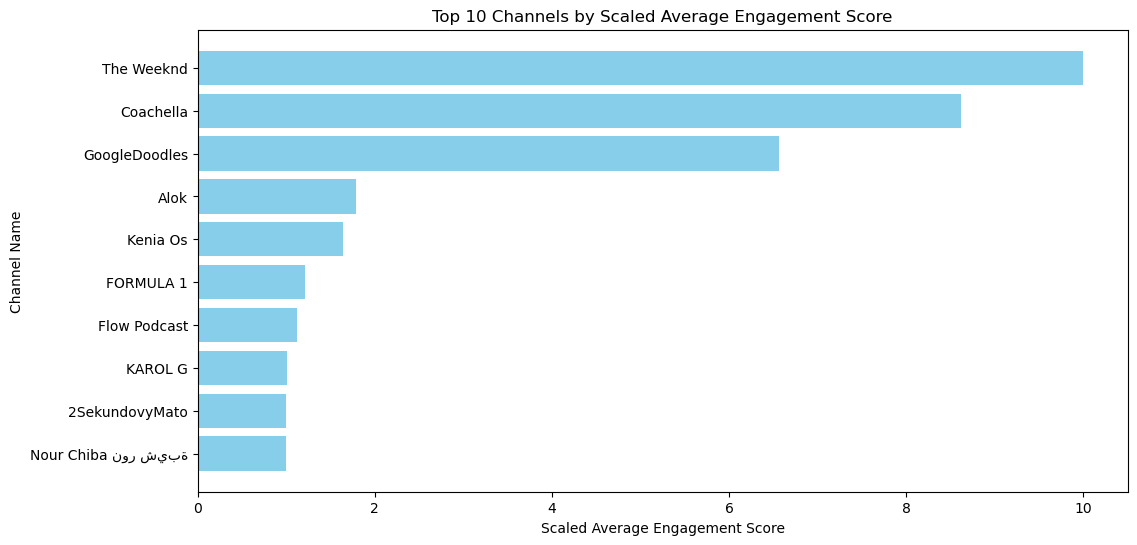

In [7]:
channel_analysis = channel_analysis.sort_values(by="scaled_avg_engagement_score", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(channel_analysis["channel_name"][:10], channel_analysis["scaled_avg_engagement_score"][:10], color='skyblue')
plt.xlabel("Scaled Average Engagement Score")
plt.ylabel("Channel Name")
plt.title("Top 10 Channels by Scaled Average Engagement Score")
plt.gca().invert_yaxis() 
plt.show()

In [9]:
#busca canales similares segun su enagement_score
#cosine : medir qué tan parecidos son dos canales según sus características numéricas, en este caso el scaled_avg_engagement_score.


from sklearn.metrics.pairwise import cosine_similarity

# 1️⃣ Creamos una matriz para calcular similitud
channel_matrix = channel_analysis[["scaled_avg_engagement_score"]].values

# 2️⃣ Similitud coseno entre canales
similarity_matrix = cosine_similarity(channel_matrix)  #we use the similitud of the cosine

# 3️⃣ Creamos un índice para buscar fácilmente por nombre
channel_names = channel_analysis["channel_name"].values
channel_index = {name: idx for idx, name in enumerate(channel_names)}

# 4️⃣ Función para recomendar canales similares
def recommend_similar_channels(channel_name, top_n=5):
    if channel_name not in channel_index:
        print(f"❌ Canal '{channel_name}' no encontrado.")
        return []

    idx = channel_index[channel_name]
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # Ordenamos por similitud (excepto el mismo canal)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_similar = sim_scores[1:top_n+1]  # omitimos el primero (es él mismo)

    print(f"📺 Canales similares a '{channel_name}':")
    for i, score in top_similar:
        print(f"  - {channel_names[i]} (Similitud: {score:.3f})")

    return [channel_names[i] for i, _ in top_similar]

# 🔍 Ejemplo: buscar similares a "The Weeknd"
recommend_similar_channels("The Weeknd", top_n=5)


📺 Canales similares a 'The Weeknd':
  - Coachella (Similitud: 1.000)
  - GoogleDoodles (Similitud: 1.000)
  - Alok (Similitud: 1.000)
  - Kenia Os (Similitud: 1.000)
  - FORMULA 1 (Similitud: 1.000)


['Coachella', 'GoogleDoodles', 'Alok', 'Kenia Os', 'FORMULA 1']

## Lets try to find similarities between videos

In [8]:
data.head(5)

,title,channel_name,view_count,like_count,comment_count,video_tags,kind,publish_date,langauge,engagement_score,scaled_engagement_score
0,Jah Prayzah - Mandionei (Official Performance ...,Jah Prayzah,640294,33578,6942,NaN,youtube#video,2025-02-17 00:00:00+00:00,NaN,0.137409,1.000001
1,Winky D - Siya,winkyonline,1483949,59662,10408,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN,0.101451,1.000001
2,Winky D Fake Love (Official Ai Video),winkyonline,1031541,48158,6185,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN,0.111359,1.000001
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,NFL,75930862,2735285,161203,"NFL, Football, American Football, sport, sports",youtube#video,2025-02-10 00:00:00+00:00,en,0.078416,1.000001
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,Man City,4166631,64473,3630,"man city, manchester city, mcfc, man city high...",youtube#video,2025-02-20 00:00:00+00:00,en-GB,0.033561,1.000000


# Sentiment Analysis

Now we will focus on analysing and filtering important data on the tags and title columns. With this method, we will be able to identify key words to generate relationships

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/adriana/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nlt

True

In [13]:
data["video_tags"] = data["video_tags"].astype(str).str.lower()

data["tokens"] = data["video_tags"].apply(word_tokenize)

stop_words = set(stopwords.words("english"))
data["filtered_tokens"] = data["tokens"].apply(lambda words: [w for w in words if w not in stop_words])

# Convert tokens back into a string for sentiment analysis
data["clean_text"] = data["filtered_tokens"].apply(lambda words: " ".join(words))

# Apply Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()
data["sentiment_score"] = data["clean_text"].apply(lambda text: sia.polarity_scores(text)["compound"])

# Categorize sentiment based on score
data["sentiment"] = data["sentiment_score"].apply(lambda score: 
    "positive" if score > 0.05 else ("negative" if score < -0.05 else "neutral"))

# Show the results
data[["title", "video_tags", "clean_text", "sentiment_score", "sentiment"]].head()

,title,video_tags,clean_text,sentiment_score,sentiment
0,Jah Prayzah - Mandionei (Official Performance ...,nan,nan,0.0000,neutral
1,Winky D - Siya,nan,nan,0.0000,neutral
2,Winky D Fake Love (Official Ai Video),nan,nan,0.0000,neutral
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,"nfl, football, american football, sport, sports","nfl , football , american football , sport , s...",0.0000,neutral
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,"man city, manchester city, mcfc, man city high...","man city , manchester city , mcfc , man city h...",0.7783,positive


In [14]:
#here we try to implement vader
sia = SentimentIntensityAnalyzer()


data["clean_text"] = data["clean_text"].fillna("")


data["sentiment_score"] = data["clean_text"].apply(lambda text: sia.polarity_scores(text)["compound"])


data["sentiment"] = data["sentiment_score"].apply(lambda score: 
    "positive" if score > 0.05 else ("negative" if score < -0.05 else "neutral"))

data[["title", "video_tags", "clean_text", "sentiment_score", "sentiment"]].head()


,title,video_tags,clean_text,sentiment_score,sentiment
0,Jah Prayzah - Mandionei (Official Performance ...,nan,nan,0.0000,neutral
1,Winky D - Siya,nan,nan,0.0000,neutral
2,Winky D Fake Love (Official Ai Video),nan,nan,0.0000,neutral
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,"nfl, football, american football, sport, sports","nfl , football , american football , sport , s...",0.0000,neutral
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,"man city, manchester city, mcfc, man city high...","man city , manchester city , mcfc , man city h...",0.7783,positive


In [15]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(n_features=5000, alternate_sign=False)

data_tf = vectorizer.transform(data["clean_text"])

def sparse_to_dataframe(sparse_matrix, column_prefix="feature"):

    df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)
    df.columns = [f"{column_prefix}_{i}" for i in range(df.shape[1])]
    return df

data_tf_df = sparse_to_dataframe(data_tf)

data_tf_df.insert(0, "title", data["title"].values)

data_tf_df.head()

,title,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_4990,feature_4991,feature_4992,feature_4993,feature_4994,feature_4995,feature_4996,feature_4997,feature_4998,feature_4999
0,Jah Prayzah - Mandionei (Official Performance ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Winky D - Siya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Winky D Fake Love (Official Ai Video),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Clustering


With the ability to find videos based on sentiment results, we can now expand to providing especific inputs, as a "new users", to obtain recommendations

In [16]:
from sklearn.neighbors import NearestNeighbors

def recommend_videos(user_sentiment, num_recommendations=5, sample_size=100):
    # 🔹 Filtrar videos con el sentimiento deseado
    filtered_videos = data[data["sentiment"] == user_sentiment]

    if filtered_videos.empty or len(filtered_videos) < num_recommendations:
        print("No hay suficientes videos con este sentimiento.")
        return []

    # 🔹 Obtener los índices comunes entre videos y features
    filtered_indices = filtered_videos.index.intersection(data_tf_df.index)

    if filtered_indices.empty:
        print("No se encontraron coincidencias con los datos vectorizados.")
        return []

    # 🔹 Seleccionar características (excepto columna 'title')
    features_matrix = data_tf_df.loc[filtered_indices, data_tf_df.columns[1:]]

    if features_matrix.shape[0] < 2:
        print("No hay suficientes datos para recomendar.")
        return []

    # 🔹 Tomar una muestra aleatoria (máx sample_size)
    sampled_indices = np.random.choice(features_matrix.index, min(sample_size, len(features_matrix)), replace=False)
    sampled_features = features_matrix.loc[sampled_indices]

    # 🔹 Fit y buscar vecinos
    nn_model = NearestNeighbors(n_neighbors=num_recommendations + 1, metric="cosine")
    nn_model.fit(sampled_features)

    # 🔹 Elegir uno de los vídeos muestreados para buscar similares
    query_vector = sampled_features.iloc[[0]]  # Puedes cambiar a `.sample(1)` si quieres aleatoriedad

    distances, indices = nn_model.kneighbors(query_vector)
    
    recommended_indices = sampled_features.iloc[indices[0][1:]].index  # Saltamos el primer (él mismo)

    recommended_titles = data.loc[recommended_indices]["title"].tolist()
    return recommended_titles, sampled_features, indices

# Ejecución
recommendations, sampled_features, neighbor_indices = recommend_videos(user_sentiment="positive", num_recommendations=5, sample_size=500)
print("🎬 Videos Recomendados:", recommendations)


🎬 Videos Recomendados: ['এক্স যখন পুলিশ | Prank King | Tuhin Chowdhury | Saila Sathy | S R Sobuj | Bangla New Natok 2023', 'A teacher captured the cutest moment at the nursery #shorts', 'Pitakavare  (පිටකවරේ)  | Group Song | Dream Star Season 11 | Top 06 | Team 01 | TV Derana', 'AMIT ❤️ ROHITA || Shaadi 😍', 'Kishori | Khadaan | Dev | Idhika | Antara Mitra | Rathijit Bhattacharjee | Ritam Sen | Soojit']


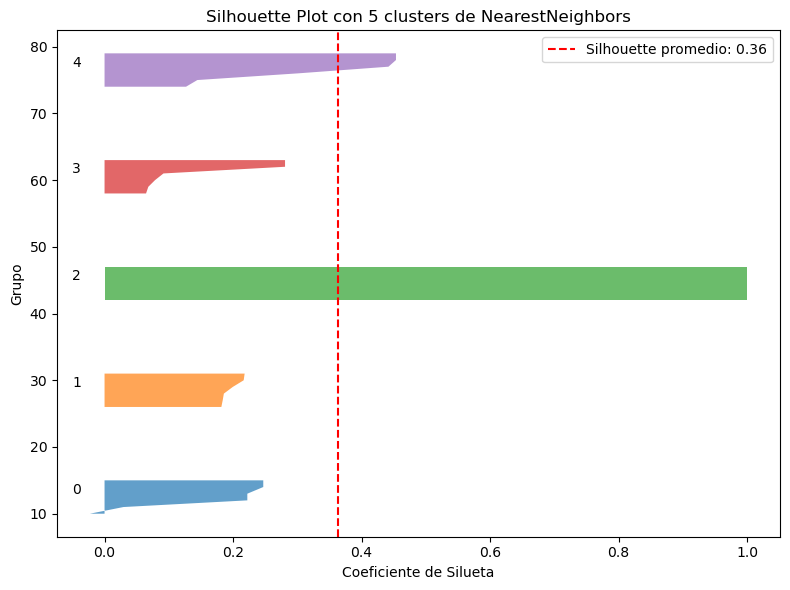

0.3638591980282003

In [17]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

def clustering_with_neighbors(data_tf_df, data, user_sentiment="positive", num_queries=5, num_recommendations=5, sample_size=500):
    filtered_videos = data[data["sentiment"] == user_sentiment]
    filtered_indices = filtered_videos.index.intersection(data_tf_df.index)

    if filtered_indices.empty:
        print("No se encontraron coincidencias.")
        return

    features_matrix = data_tf_df.loc[filtered_indices, data_tf_df.columns[1:]]
    if features_matrix.shape[0] < 2:
        print("Datos insuficientes.")
        return

    # Muestra aleatoria
    sampled_indices = np.random.choice(features_matrix.index, min(sample_size, len(features_matrix)), replace=False)
    sampled_features = features_matrix.loc[sampled_indices]
    
    # Inicializamos
    cluster_labels = np.full(len(sampled_features), -1)
    cluster_id = 0
    
    nn_model = NearestNeighbors(n_neighbors=num_recommendations + 1, metric="cosine")
    nn_model.fit(sampled_features)

    used_indices = set()

    for i in range(num_queries):
        query_idx = np.random.choice(sampled_features.index.difference(used_indices))
        distances, indices = nn_model.kneighbors(sampled_features.loc[[query_idx]])
        group_indices = sampled_features.iloc[indices[0]].index

        for idx in group_indices:
            cluster_labels[sampled_features.index.get_loc(idx)] = cluster_id
            used_indices.add(idx)
        
        cluster_id += 1

    # Filtrar datos válidos
    valid_mask = cluster_labels != -1
    final_features = sampled_features[valid_mask]
    final_labels = cluster_labels[valid_mask]

    # Silhouette Score
    sil_score = silhouette_score(final_features, final_labels)
    sil_values = silhouette_samples(final_features, final_labels)

    # Gráfico
    fig, ax = plt.subplots(figsize=(8, 6))
    y_lower = 10
    for i in np.unique(final_labels):
        ith_values = sil_values[final_labels == i]
        ith_values.sort()
        size = len(ith_values)
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_values, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size, str(i))
        y_lower = y_upper + 10

    ax.axvline(sil_score, color="red", linestyle="--", label=f"Silhouette promedio: {sil_score:.2f}")
    ax.set_title(f"Silhouette Plot con {num_queries} clusters de NearestNeighbors")
    ax.set_xlabel("Coeficiente de Silueta")
    ax.set_ylabel("Grupo")
    ax.legend()
    plt.tight_layout()
    plt.show()

    return sil_score

clustering_with_neighbors(data_tf_df, data, user_sentiment="positive", num_queries=5, num_recommendations=5, sample_size=500)


We tried using cornac experinment, as in notebook 5.1, but given we do not have any users, data was unconclusive and did not provide useful information. Thus we will carry on with the next steps.

ITEM-BASED METHODS

In [18]:
import cornac
from cornac.models import ItemKNN
from cornac.eval_methods import RatioSplit
from cornac.metrics import RMSE
# Quedarte solo con los 5000 vídeos con mayor engagement
top_items = data.sort_values(by="engagement_score", ascending=False).head(100000)

cornac_data = top_items[["title", "engagement_score"]].copy()
cornac_data["user"] = "viewer"
cornac_data.rename(columns={"title": "item", "engagement_score": "rating"}, inplace=True)


# Convertimos a formato que Cornac espera: lista de tuplas (user, item, rating)
cornac_tuples = cornac_data[["user", "item", "rating"]].values.tolist()

# Paso 2: Dividimos los datos (90% entrenamiento, 10% test)
ratio_split = RatioSplit(data=cornac_tuples, test_size=0.1, seed=42, verbose=True)

# Paso 3: Definimos los modelos ItemKNN con diferentes configuraciones
K = 50  # Número de vecinos

iknn_cosine = ItemKNN(k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=True)
iknn_pearson = ItemKNN(k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=True)
iknn_pearson_mc = ItemKNN(k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=True)
iknn_adjusted = ItemKNN(k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=True)

# Paso 4: Ejecutamos el experimento
cornac.Experiment(
    eval_method=ratio_split,
    models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
    metrics=[RMSE()]
).run()


/home/adriana/anaconda3/envs/bigdata/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/adriana/anaconda3/envs/bigdata/lib/python3.10/site-packages/cornac/data/dataset.py:335: UserWarning: 76537 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/home/adriana/anaconda3/envs/bigdata/lib/python3.10/site-packages/cornac/data/dataset.py:335: UserWarning: 5779 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 1
Number of items = 13463
Number of ratings = 13463
Max rating = 833800.0
Min rating = 0.2
Global mean = 169.4
---
Test data:
Number of users = 1
Number of items = 13463
Number of ratings = 3579
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 1
Total items = 13463

[ItemKNN-Cosine] Training started!


100%|██████████| 13463/13463 [00:00<00:00, 20266.98it/s]



[ItemKNN-Cosine] Evaluation started!


Rating: 100%|██████████| 3579/3579 [00:00<00:00, 10701.81it/s]



[ItemKNN-Pearson] Training started!


100%|██████████| 13463/13463 [00:00<00:00, 20663.73it/s]



[ItemKNN-Pearson] Evaluation started!


Rating: 100%|██████████| 3579/3579 [00:00<00:00, 9787.12it/s] 



[ItemKNN-Pearson-MC] Training started!


100%|██████████| 13463/13463 [00:00<00:00, 19564.21it/s]



[ItemKNN-Pearson-MC] Evaluation started!


Rating: 100%|██████████| 3579/3579 [00:00<00:00, 11049.01it/s]



[ItemKNN-AdjustedCosine] Training started!


100%|██████████| 13463/13463 [00:00<00:00, 21300.55it/s]



[ItemKNN-AdjustedCosine] Evaluation started!


Rating: 100%|██████████| 3579/3579 [00:00<00:00, 10289.03it/s]


TEST:
...
                       |       RMSE | Train (s) | Test (s)
---------------------- + ---------- + --------- + --------
ItemKNN-Cosine         | 18778.6659 |    4.3540 |   0.3392
ItemKNN-Pearson        | 18778.6557 |    4.4519 |   0.3691
ItemKNN-Pearson-MC     | 18778.6557 |    4.2104 |   0.3266
ItemKNN-AdjustedCosine | 17323.6241 |    4.8913 |   0.3500



In [20]:
# Obtener la matriz de puntuación del modelo entrenado
rating_mat = iknn_adjusted.train_set.matrix

# Obtener los índices del usuario e ítems
user_idxid = list(iknn_adjusted.train_set.uid_map)  # ["viewer"]
item_idx2id = list(iknn_adjusted.train_set.item_ids)  # títulos de los vídeos

# Como solo tienes un usuario, su índice será 0
TOPK = 10
UIDX = 0  # "viewer"

# Obtener todas las predicciones del usuario
rating_arr = rating_mat[UIDX].A.ravel()

# Obtener los índices de los ítems con mejor puntuación
top_rated_items = np.argsort(rating_arr)[-TOPK:]

# Mostrar los resultados
print(f"\n🎬 TOP {TOPK} VIDEOS RECOMENDADOS para el usuario 'viewer':")
for i in reversed(top_rated_items):  # los mejores primero
    print(f"- {item_idx2id[i]} (score: {rating_arr[i]:.2f})")



🎬 TOP 10 VIDEOS RECOMENDADOS para el usuario 'viewer':
- THE WEEKND - SÃO PAULO LIVESTREAM (score: 833800.00)
- All 20 Drivers. All 10 Teams. UNVEILED. | F1 75 Live at The O2 (score: 469380.00)
- Sahara 🔴 Live from Coachella 2024 (score: 267346.00)
- Coachella Stage 🔴 Live from Coachella 2024 (score: 245600.00)
- Celebrating Juan Gabriel (score: 167140.00)
- LIVE - AUREA TOUR BELÉM (score: 93851.00)
- SHOW ALOK AO VIVO - BSB 6.4 (score: 68579.00)
- KAROL G, Tiësto - CONTIGO (Afterparty) (score: 61218.00)
- Kenia OS, El Malilla - Un Bezito (Red Carpet) (score: 38658.00)
- Outdoor Theatre 🔴 Live from Coachella 2024 (score: 28870.00)


In [21]:
# Número de recomendaciones que deseas mostrar
TOPK = 10
UIDX = 0  # índice del usuario simulado "viewer"

# Obtener recomendaciones y sus puntuaciones
recommendations, scores = iknn_adjusted.rank(UIDX)

# Mostrar puntuaciones de los TOPK recomendados
print(f"\n🎯 TOP {TOPK} RECOMENDACIONES para el usuario 'viewer':")
for i in range(TOPK):
    item_id = recommendations[i]
    title = iknn_adjusted.train_set.item_ids[item_id]
    score = scores[item_id]
    print(f"{i+1}. {title} (score: {score:.2f})")



🎯 TOP 10 RECOMENDACIONES para el usuario 'viewer':
1. Sahara 🔴 Live from Coachella 2024 (score: 45807.36)
2. Kenia OS, El Malilla - Un Bezito (Red Carpet) (score: 45807.36)
3. All 20 Drivers. All 10 Teams. UNVEILED. | F1 75 Live at The O2 (score: 45807.35)
4. KAROL G, Tiësto - CONTIGO (Afterparty) (score: 45807.35)
5. LIVE - AUREA TOUR BELÉM (score: 45807.35)
6. Celebrating Juan Gabriel (score: 45807.35)
7. Se ruuuuuuuuuuuuuuus boys  Do chatu piis   !mato !donate !dc  !GG (score: 45807.35)
8. THE WEEKND - SÃO PAULO LIVESTREAM (score: 45807.34)
9. Outdoor Theatre 🔴 Live from Coachella 2024 (score: 45807.34)
10. Coachella Stage 🔴 Live from Coachella 2024 (score: 45807.34)


In [22]:
from collections import defaultdict
import numpy as np
import pandas as pd

# Usuario simulado
UIDX = 0
TOPK = 5

# Obtener matriz de puntuaciones y similitudes
rating_mat = iknn_adjusted.train_set.matrix
score_arr = iknn_adjusted.ui_mat[UIDX].A.ravel()
rated_items = np.nonzero(rating_mat[UIDX])[1]  # Ítems que ya ha valorado

# Preparar estructura de datos
df = defaultdict(list)

# Analizar cada recomendación
for rec in recommendations[:TOPK]:
    sim_arr = iknn_adjusted.sim_mat[rec].A.ravel()  # Similitudes del ítem recomendado
    nearest_neighbor = rated_items[np.argsort(sim_arr[rated_items])[-1]]  # El más similar ya visto
    sim = sim_arr[nearest_neighbor]
    score = score_arr[nearest_neighbor]
    
    # Recuperar nombres
    item_name = cornac_data[cornac_data["item"] == iknn_adjusted.train_set.item_ids[rec]]["item"].values[0]
    nn_name = cornac_data[cornac_data["item"] == iknn_adjusted.train_set.item_ids[nearest_neighbor]]["item"].values[0]
    
    # Guardar datos
    df["Recommendation"].append(item_name)
    df["Item NN"].append(nn_name)
    df["Similarity"].append(sim)
    df["Score of the NN"].append(score)
    df["Contribution"].append((score * sim) / np.abs(sim))

# Crear DataFrame bonito
rec_df = pd.DataFrame.from_dict(df)
display(rec_df)


,Recommendation,Item NN,Similarity,Score of the NN,Contribution
0,Sahara 🔴 Live from Coachella 2024,"Kenia OS, El Malilla - Un Bezito (Red Carpet)",1.0,38488.553288,38488.553288
1,"Kenia OS, El Malilla - Un Bezito (Red Carpet)",Sahara 🔴 Live from Coachella 2024,1.0,267176.553288,267176.553288
2,All 20 Drivers. All 10 Teams. UNVEILED. | F1 7...,SHOW ALOK AO VIVO - BSB 6.4,1.0,68409.553288,68409.553288
3,"KAROL G, Tiësto - CONTIGO (Afterparty)",Outdoor Theatre 🔴 Live from Coachella 2024,1.0,28700.553288,28700.553288
4,LIVE - AUREA TOUR BELÉM,Se ruuuuuuuuuuuuuuus boys Do chatu piis !ma...,1.0,2551.553288,2551.553288
